In [1]:
!lscpu |grep 'Model name'
!nvidia-smi
!pip install ax-platform

Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
Mon Mar 20 18:09:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [2]:
import pandas as pd
from ax import *
import torch

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

from ax.service.utils.report_utils import exp_to_df
from ax.runners.synthetic import SyntheticRunner
from ax.metrics.noisy_function import GenericNoisyFunctionMetric

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

from botorch.test_functions.multi_objective import DTLZ5

In [3]:
tkwargs = {
    "dtype": torch.double, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [4]:
dim = 30
problem = DTLZ5(num_objectives=2, dim=dim, negate=False).to(**tkwargs)

param_names = [f"x{i}" for i in range(dim)]

def f1(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names] # Obtiene los parámetros a evaluar
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[0]) # Evalúa los parámetros en el primer objetivo
    
def f2(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names]
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[1]) # Evalúa los parámetros en el segundo objetivo

metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=True)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=True)

In [5]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name=param_name, lower=0, upper=1, parameter_type=ParameterType.FLOAT)
        for param_name in param_names
        ]
)

mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, problem.ref_point)
]

optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

In [6]:
N_INIT = 2 * (dim + 1)
N_BATCH = 10
BATCH_SIZE = 1

def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()

    return experiment.fetch_data()

In [7]:
import time

executions = 10
execution_times = []
all_df = []
all_outcomes = []

for exec in range(executions):
  start_time = time.time()

  experiment = build_experiment()
  data = initialize_experiment(experiment)

  hv_list = []
  model = None
  for i in range(N_BATCH):   
      model = Models.FULLYBAYESIANMOO(
          experiment=experiment, 
          data=data,
          num_samples=16,
          warmup_steps=32,
          torch_device=tkwargs["device"],
      )
      generator_run = model.gen(BATCH_SIZE)
      trial = experiment.new_trial(generator_run=generator_run)
      trial.run()
      data = Data.from_multiple_data([data, trial.fetch_data()])
      
      exp_df = exp_to_df(experiment)
      outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
      try:
          hv = observed_hypervolume(modelbridge=model)
      except:
          hv = 0
          print("Failed to compute hv")
      hv_list.append(hv)
      print(f"Execution: {exec + 1}, Iteration: {i + 1}, HV: {hv}")

  execution_times.append(time.time() - start_time)

  all_df.append(exp_to_df(experiment).sort_values(by=["trial_index"]))
  all_outcomes.append(np.array(exp_to_df(experiment)[['a', 'b']], dtype=np.double))

Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=2.67e-01, acc. prob=0.697]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 1, HV: 92.44763067168896


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=3.12e-01, acc. prob=0.934]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 2, HV: 92.55317471940464


Sample: 100%|██████████| 48/48 [00:19,  2.53it/s, step size=4.01e-01, acc. prob=0.705]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 3, HV: 92.72945222783163


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=2.55e-01, acc. prob=0.926]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 4, HV: 92.72945222783163


Sample: 100%|██████████| 48/48 [00:18,  2.57it/s, step size=2.49e-01, acc. prob=0.895]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 5, HV: 92.72945222783163


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=2.08e-01, acc. prob=0.941]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 6, HV: 92.72945222783163


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=4.60e-01, acc. prob=0.526]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 7, HV: 92.72945222783163


Sample: 100%|██████████| 48/48 [00:15,  3.09it/s, step size=7.69e-01, acc. prob=0.046]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 8, HV: 92.75458807831525


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=3.68e-01, acc. prob=0.584]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 9, HV: 92.75458807831525


Sample: 100%|██████████| 48/48 [00:18,  2.66it/s, step size=2.95e-01, acc. prob=0.849]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 10, HV: 92.75458807831525


Sample: 100%|██████████| 48/48 [00:18,  2.58it/s, step size=2.67e-01, acc. prob=0.694]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 1, HV: 93.8620850546059


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=3.30e-01, acc. prob=0.825]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 2, HV: 93.9906351881553


Sample: 100%|██████████| 48/48 [00:18,  2.62it/s, step size=4.09e-01, acc. prob=0.640]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 3, HV: 94.00233433173952


Sample: 100%|██████████| 48/48 [00:14,  3.37it/s, step size=4.54e-01, acc. prob=0.043]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 4, HV: 94.00233433173952


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=1.55e-01, acc. prob=0.892]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 5, HV: 94.00233433173952


Sample: 100%|██████████| 48/48 [00:17,  2.67it/s, step size=3.13e-01, acc. prob=0.812]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 6, HV: 94.00233433173952


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=1.53e-01, acc. prob=0.925]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 7, HV: 94.00233433173952


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=1.59e-01, acc. prob=0.916]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 8, HV: 94.00233433173952


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=3.70e-01, acc. prob=0.482]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 9, HV: 94.00233433173952


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=1.52e-01, acc. prob=0.942]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 10, HV: 94.16281656797878


Sample: 100%|██████████| 48/48 [00:18,  2.58it/s, step size=3.96e-01, acc. prob=0.575]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 1, HV: 92.98980639129131


Sample: 100%|██████████| 48/48 [00:18,  2.59it/s, step size=4.82e-01, acc. prob=0.670]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 2, HV: 93.39129665822101


Sample: 100%|██████████| 48/48 [00:11,  4.02it/s, step size=4.28e-01, acc. prob=0.055]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 3, HV: 93.43441564248644


Sample: 100%|██████████| 48/48 [00:19,  2.51it/s, step size=3.09e-01, acc. prob=0.659]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 4, HV: 93.43441564248644


Sample: 100%|██████████| 48/48 [00:19,  2.40it/s, step size=3.49e-01, acc. prob=0.686]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 5, HV: 93.46793143519652


Sample: 100%|██████████| 48/48 [00:17,  2.81it/s, step size=4.19e-01, acc. prob=0.204]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 6, HV: 93.46793143519652


Sample: 100%|██████████| 48/48 [00:19,  2.43it/s, step size=2.76e-01, acc. prob=0.766]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 7, HV: 93.46793143519652


Sample: 100%|██████████| 48/48 [00:15,  3.19it/s, step size=5.98e-01, acc. prob=0.135]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 8, HV: 93.46793143519652


Sample: 100%|██████████| 48/48 [00:15,  3.13it/s, step size=3.92e-01, acc. prob=0.080]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 9, HV: 93.46793143519652


Sample: 100%|██████████| 48/48 [00:20,  2.40it/s, step size=2.58e-01, acc. prob=0.878]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 10, HV: 93.46793143519652


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=3.02e-01, acc. prob=0.811]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 1, HV: 92.70122269000424


Sample: 100%|██████████| 48/48 [00:18,  2.57it/s, step size=3.00e-01, acc. prob=0.894]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 2, HV: 92.82034703436359


Sample: 100%|██████████| 48/48 [00:14,  3.41it/s, step size=5.86e-01, acc. prob=0.069]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 3, HV: 92.88485368166415


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=5.71e-01, acc. prob=0.205]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 4, HV: 92.88485368166415


Sample: 100%|██████████| 48/48 [00:18,  2.54it/s, step size=2.72e-01, acc. prob=0.779]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 5, HV: 92.88485368166415


Sample: 100%|██████████| 48/48 [00:19,  2.40it/s, step size=1.34e-01, acc. prob=0.921]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 6, HV: 92.88485368166415


Sample: 100%|██████████| 48/48 [00:18,  2.57it/s, step size=2.83e-01, acc. prob=0.486]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 7, HV: 92.88485368166415


Sample: 100%|██████████| 48/48 [00:19,  2.46it/s, step size=2.99e-01, acc. prob=0.805]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 8, HV: 92.88485368166415


Sample: 100%|██████████| 48/48 [00:19,  2.49it/s, step size=3.07e-01, acc. prob=0.906]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 9, HV: 92.88511633481605


Sample: 100%|██████████| 48/48 [00:18,  2.56it/s, step size=1.84e-01, acc. prob=0.902]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 10, HV: 92.93481294862575


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=3.01e-01, acc. prob=0.885]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 1, HV: 92.70411285551718


Sample: 100%|██████████| 48/48 [00:19,  2.46it/s, step size=3.01e-01, acc. prob=0.409]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 2, HV: 92.73301287642506


Sample: 100%|██████████| 48/48 [00:17,  2.76it/s, step size=2.01e-01, acc. prob=0.068]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 3, HV: 92.74003094103468


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=3.22e-01, acc. prob=0.850]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 4, HV: 92.78189573195354


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=1.09e-01, acc. prob=0.974]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 5, HV: 92.78189573195354


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=1.58e-01, acc. prob=0.903]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 6, HV: 92.79718020654605


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=2.40e-01, acc. prob=0.884]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 7, HV: 92.79718020654605


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=4.54e-01, acc. prob=0.581]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 8, HV: 92.79718020654605


Sample: 100%|██████████| 48/48 [00:18,  2.56it/s, step size=1.61e-01, acc. prob=0.680]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 9, HV: 92.79718020654605


Sample: 100%|██████████| 48/48 [00:14,  3.21it/s, step size=2.25e-01, acc. prob=0.127]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 10, HV: 92.79718020654605


Sample: 100%|██████████| 48/48 [00:18,  2.56it/s, step size=2.45e-01, acc. prob=0.904]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 1, HV: 92.94265106779436


Sample: 100%|██████████| 48/48 [00:18,  2.61it/s, step size=4.78e-01, acc. prob=0.236]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 2, HV: 92.95451893284567


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=2.70e-01, acc. prob=0.920]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 3, HV: 93.11035046475111


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=3.58e-01, acc. prob=0.720]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 4, HV: 93.11175322358831


Sample: 100%|██████████| 48/48 [00:14,  3.40it/s, step size=5.83e-01, acc. prob=0.068]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 5, HV: 93.11175322358831


Sample: 100%|██████████| 48/48 [00:14,  3.20it/s, step size=3.14e-01, acc. prob=0.052]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 6, HV: 93.11175322358831


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=1.99e-01, acc. prob=0.405]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 7, HV: 93.11175322358831


Sample: 100%|██████████| 48/48 [00:18,  2.58it/s, step size=1.49e-01, acc. prob=0.920]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 8, HV: 93.11327343095937


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=3.85e-01, acc. prob=0.316]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 9, HV: 93.11327343095937


Sample: 100%|██████████| 48/48 [00:19,  2.49it/s, step size=4.39e-01, acc. prob=0.331]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 10, HV: 93.11327343095937


Sample: 100%|██████████| 48/48 [00:18,  2.53it/s, step size=3.78e-01, acc. prob=0.617]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 1, HV: 92.44028669094313


Sample: 100%|██████████| 48/48 [00:13,  3.64it/s, step size=5.49e-01, acc. prob=0.089]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 2, HV: 92.56189738785507


Sample: 100%|██████████| 48/48 [00:17,  2.69it/s, step size=2.99e-01, acc. prob=0.848]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 3, HV: 92.57133009862096


Sample: 100%|██████████| 48/48 [00:19,  2.46it/s, step size=1.56e-01, acc. prob=0.693]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 4, HV: 92.69528809587268


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=2.39e-01, acc. prob=0.961]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 5, HV: 92.70690356546967


Sample: 100%|██████████| 48/48 [00:18,  2.54it/s, step size=4.73e-01, acc. prob=0.300]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 6, HV: 92.70690356546967


Sample: 100%|██████████| 48/48 [00:18,  2.61it/s, step size=3.73e-01, acc. prob=0.346]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 7, HV: 92.70690356546967


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=1.60e-01, acc. prob=0.903]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 8, HV: 92.70690356546967


Sample: 100%|██████████| 48/48 [00:19,  2.43it/s, step size=9.22e-02, acc. prob=0.946]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 9, HV: 92.70690356546967


Sample: 100%|██████████| 48/48 [00:19,  2.46it/s, step size=2.62e-01, acc. prob=0.575]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 10, HV: 92.70690356546967


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=3.04e-01, acc. prob=0.880]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 1, HV: 93.48551301009583


Sample: 100%|██████████| 48/48 [00:16,  2.93it/s, step size=3.37e-01, acc. prob=0.279]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 2, HV: 93.68836207672963


Sample: 100%|██████████| 48/48 [00:16,  2.90it/s, step size=5.58e-01, acc. prob=0.180]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 3, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:19,  2.51it/s, step size=3.15e-01, acc. prob=0.873]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 4, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=1.62e-01, acc. prob=0.664]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 5, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=2.01e-01, acc. prob=0.854]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 6, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=2.58e-01, acc. prob=0.907]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 7, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:18,  2.55it/s, step size=2.80e-01, acc. prob=0.893]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 8, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=4.23e-01, acc. prob=0.432]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 9, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:18,  2.61it/s, step size=3.95e-01, acc. prob=0.850]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 10, HV: 93.78501248550046


Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=1.65e-01, acc. prob=0.938]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 1, HV: 93.46938915968697


Sample: 100%|██████████| 48/48 [00:14,  3.43it/s, step size=3.07e-01, acc. prob=0.127]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 2, HV: 93.46938915968697


Sample: 100%|██████████| 48/48 [00:18,  2.60it/s, step size=1.76e-01, acc. prob=0.933]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 3, HV: 93.71171036571609


Sample: 100%|██████████| 48/48 [00:18,  2.53it/s, step size=1.17e-01, acc. prob=0.804]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 4, HV: 93.80783516589874


Sample: 100%|██████████| 48/48 [00:18,  2.54it/s, step size=2.34e-01, acc. prob=0.925]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 5, HV: 93.89386420429037


Sample: 100%|██████████| 48/48 [00:19,  2.51it/s, step size=2.53e-01, acc. prob=0.503]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 6, HV: 93.89386420429037


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=1.53e-01, acc. prob=0.903]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 7, HV: 93.89386420429037


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=2.85e-01, acc. prob=0.841]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 8, HV: 93.89386420429037


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=1.13e-01, acc. prob=0.953]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 9, HV: 93.89386420429037


Sample: 100%|██████████| 48/48 [00:18,  2.54it/s, step size=1.98e-01, acc. prob=0.910]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 10, HV: 93.89386420429037


Sample: 100%|██████████| 48/48 [00:18,  2.61it/s, step size=3.17e-01, acc. prob=0.845]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 1, HV: 91.63136495303496


Sample: 100%|██████████| 48/48 [00:17,  2.75it/s, step size=4.59e-01, acc. prob=0.386]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 2, HV: 91.80336003536115


Sample: 100%|██████████| 48/48 [00:19,  2.46it/s, step size=3.99e-01, acc. prob=0.585]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 3, HV: 91.97586518550872


Sample: 100%|██████████| 48/48 [00:19,  2.53it/s, step size=1.63e-01, acc. prob=0.854]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 4, HV: 92.03803621659867


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.45e-01, acc. prob=0.515]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 5, HV: 92.06604406313807


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=2.94e-01, acc. prob=0.811]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 6, HV: 92.06604406313807


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=1.06e-01, acc. prob=0.934]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 7, HV: 92.06604406313807


Sample: 100%|██████████| 48/48 [00:18,  2.64it/s, step size=1.46e-01, acc. prob=0.949]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 8, HV: 92.06604406313807


Sample: 100%|██████████| 48/48 [00:20,  2.37it/s, step size=3.73e-01, acc. prob=0.706]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 9, HV: 92.06604406313807


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=3.84e-01, acc. prob=0.593]


Execution: 10, Iteration: 10, HV: 92.06604406313807


/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


<ipython-input-10-f8789cb13dba>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


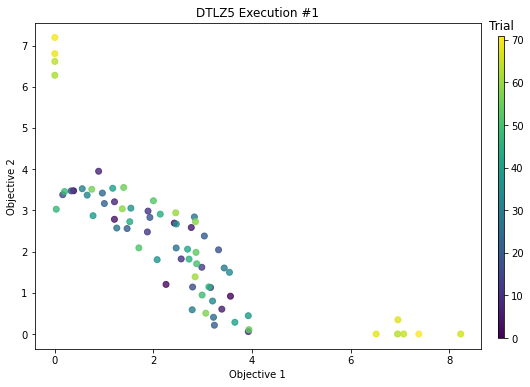

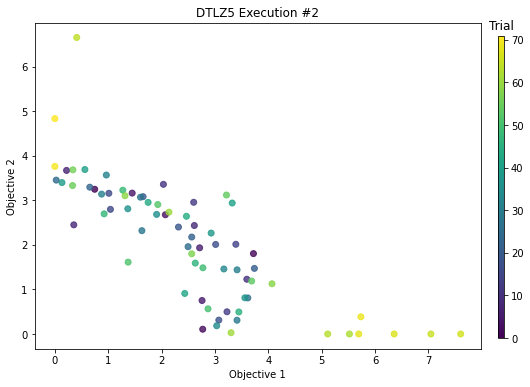

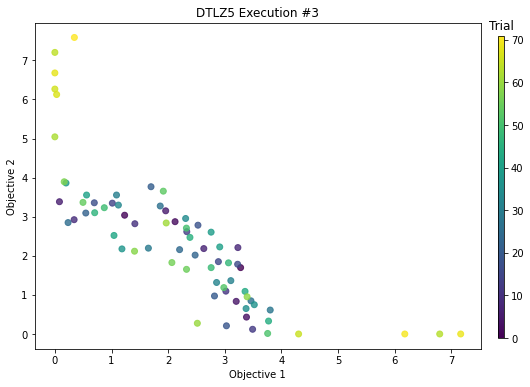

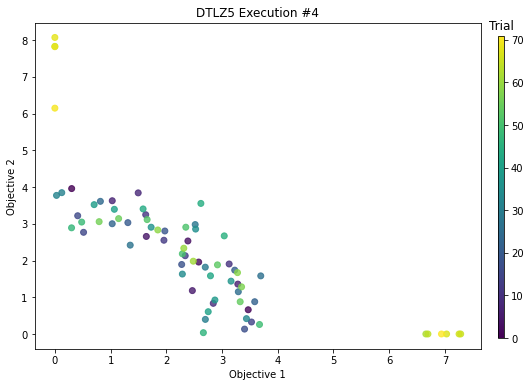

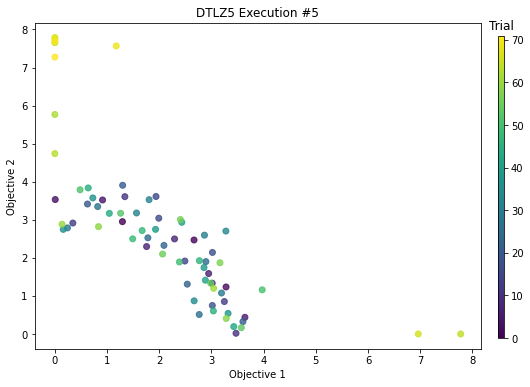

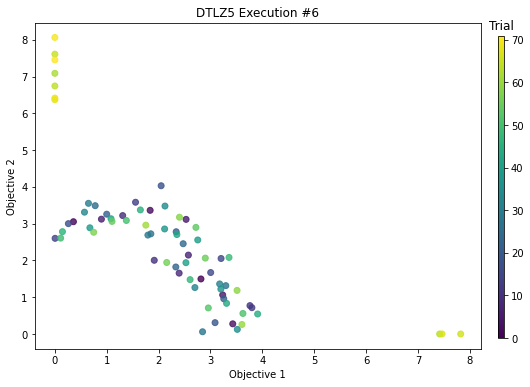

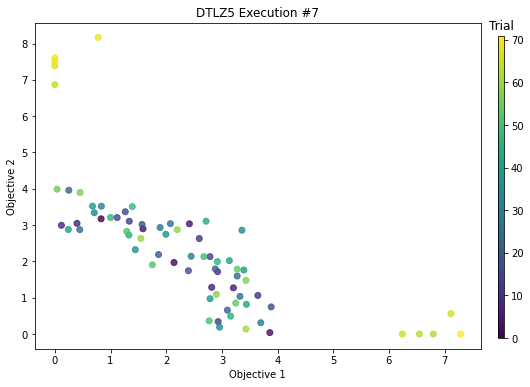

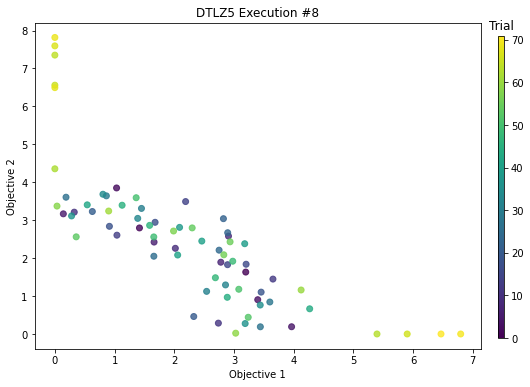

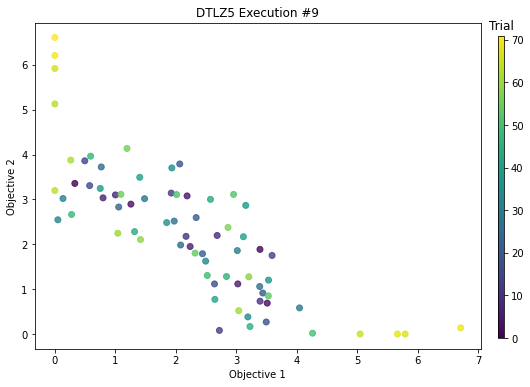

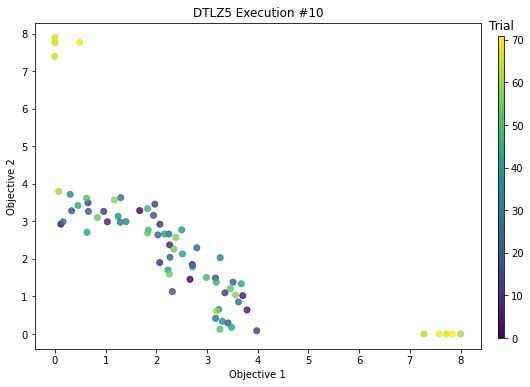

In [10]:
from torch import Tensor
%matplotlib inline

for exec in range(executions):
  fig, axes = plt.subplots(1, 1, figsize=(8,6))

  cm = plt.cm.get_cmap('viridis')
  batch_number = all_df[exec].trial_index.values
  sc = axes.scatter(all_outcomes[exec][:, 0], all_outcomes[exec][:,1], c=batch_number, alpha=0.8)
  axes.set_title(f'DTLZ5 Execution #{exec + 1}')
  axes.set_xlabel("Objective 1")
  axes.set_ylabel("Objective 2")
  norm = plt.Normalize(batch_number.min(), batch_number.max())
  sm =  ScalarMappable(norm=norm, cmap=cm)
  fig.subplots_adjust(right=0.9)
  cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
  cbar = fig.colorbar(sm, cax=cbar_ax)
  cbar.ax.set_title("Trial")

Execution times: [470.00317574 473.75645542 453.2010684  461.43413544 487.79896641
 456.5258317  486.74456167 469.69348001 452.89633536 500.6090703 ]
Average execution time: 471.2663080453873


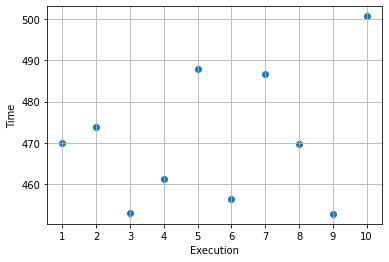

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
plt.xticks(np.arange(1, executions + 1))

axes.scatter(np.arange(1, executions + 1), np.array(execution_times))
axes.grid(True)
axes.set_xlabel("Execution")
axes.set_ylabel("Time")

print("Execution times:", np.array(execution_times))
print("Average execution time:", np.array(execution_times).sum()/len(execution_times))

In [12]:
print(all_df)

[    trial_index arm_name trial_status generation_method             a  \
0             0      0_0      RUNNING             Sobol  3.790251e-01   
1             1      1_0      RUNNING             Sobol  3.561760e+00   
2             2      2_0      RUNNING             Sobol  2.254784e+00   
3             3      3_0      RUNNING             Sobol  2.422946e+00   
4             4      4_0      RUNNING             Sobol  1.208040e+00   
..          ...      ...          ...               ...           ...   
67           67     67_0      RUNNING  FullyBayesianMOO  6.959298e+00   
68           68     68_0      RUNNING  FullyBayesianMOO  6.516911e+00   
69           69     69_0      RUNNING  FullyBayesianMOO  4.165332e-16   
70           70     70_0      RUNNING  FullyBayesianMOO  4.406008e-16   
71           71     71_0      RUNNING  FullyBayesianMOO  7.383553e+00   

           b  is_feasible        x0        x1        x2  ...       x20  \
0   3.474631         True  0.930829  0.055503  0